In [1]:
#import libraries
import pandas as pd
import numpy as np

In [2]:
data_Platium = pd.read_csv("./data/PlatiumData.csv", na_values=['null'],index_col='Ngày', parse_dates=True, infer_datetime_format=True)
data_Platium = data_Platium.drop('KL', axis=1)
data_Platium = data_Platium.replace(",", ".", regex=True)
data_Platium.dropna()

,Lần cuối,Mở,Cao,Thấp
Ngày,,,,
2018-05-20,886.2,886.8,889.0,885.5
2018-05-21,899.5,886.2,902.7,877.8
2018-05-22,908.3,899.5,912.0,896.3
2018-05-23,904.6,908.3,910.4,898.5
2018-05-24,910.4,904.6,914.7,903.5
...,...,...,...,...
2023-05-15,1082.8,1057.6,1079.1,1057.5
2023-05-16,1075.0,1070.5,1078.7,1061.8
2023-05-17,1090.7,1067.7,1086.1,1067.4


## Trực quan hóa dữ liệu

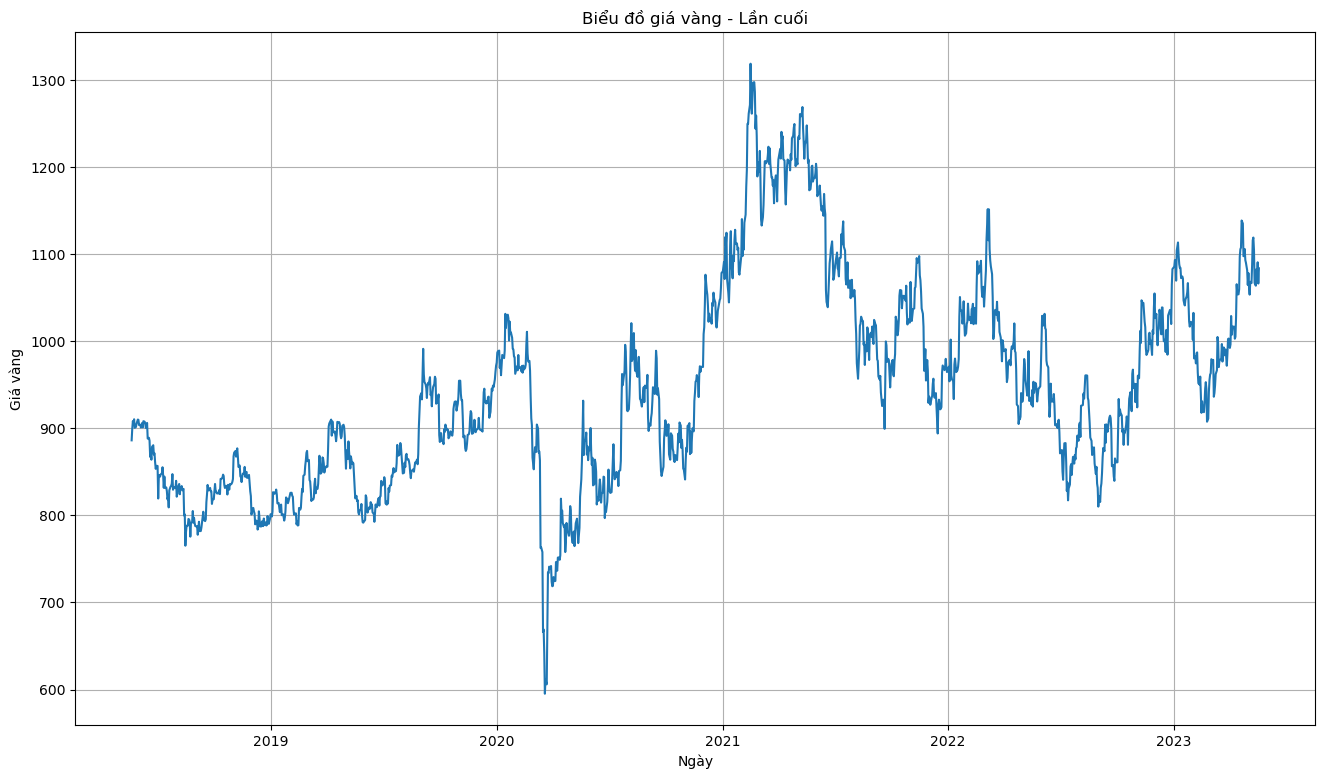

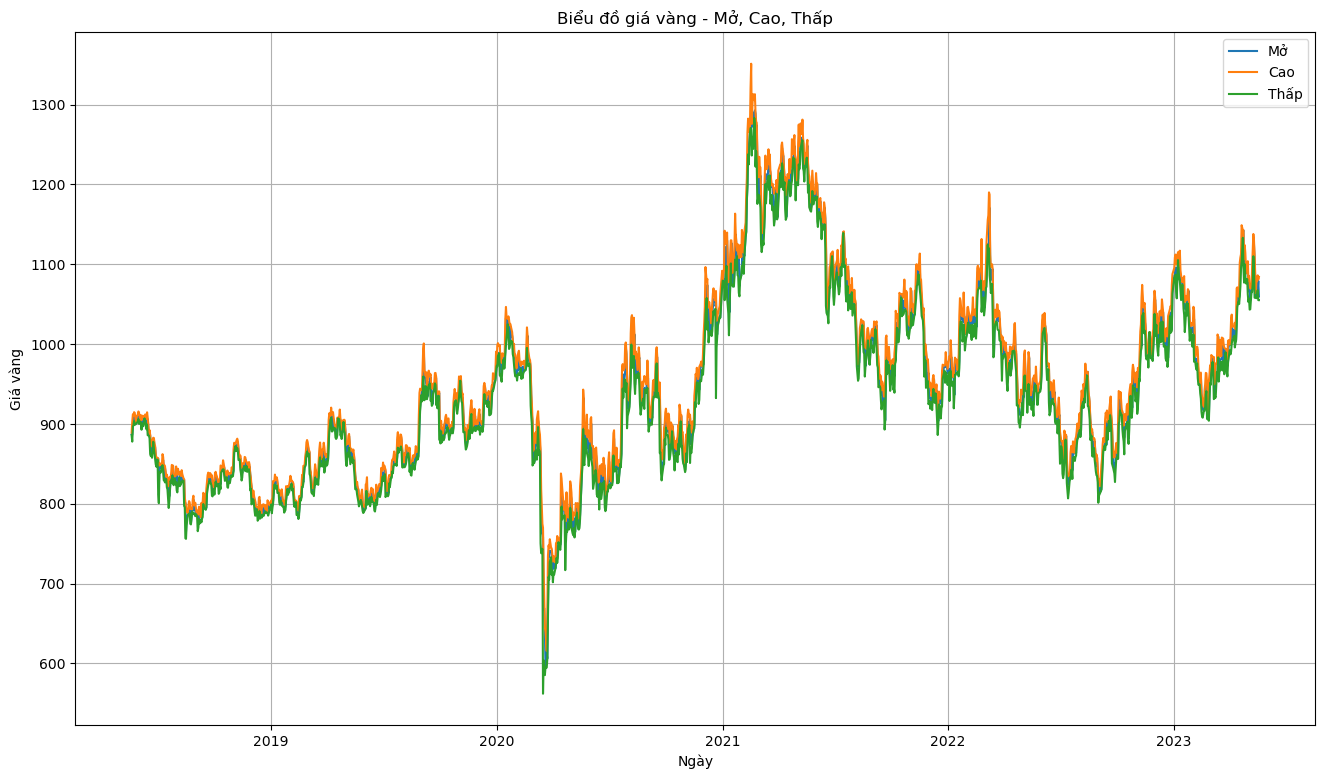

In [3]:
import matplotlib.pyplot as plt

# Trực quan hóa cột "Lần cuối"
plt.figure(figsize=(16, 9))
plt.plot(data_Platium.index, data_Platium['Lần cuối'])
plt.title('Biểu đồ giá vàng - Lần cuối')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.grid(True)
plt.show()

# Trực quan hóa cột "Mở", "Cao", "Thấp"
plt.figure(figsize=(16, 9))
plt.plot(data_Platium.index, data_Platium['Mở'], label='Mở')
plt.plot(data_Platium.index, data_Platium['Cao'], label='Cao')
plt.plot(data_Platium.index, data_Platium['Thấp'], label='Thấp')
plt.title('Biểu đồ giá vàng - Mở, Cao, Thấp')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.legend()
plt.grid(True)
plt.show()


## chia tập train, test, validate

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Chia features và target
X = data_Platium.dropna().drop(columns=['Lần cuối'])
y = data_Platium.dropna()['Lần cuối']

# Chia tập train và tập còn lại (test + validate) theo tỷ lệ 6:4
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.4, random_state=42)

# Chia tập test và tập validate từ tập còn lại theo tỷ lệ 3:1
test_size = 0.3  # 3 / (3 + 7)
X_test, X_validate, y_test, y_validate = train_test_split(X_rest, y_rest, test_size=test_size, random_state=42)

# In thông tin về kích thước tập train, test và validate
print("Kích thước tập train:", X_train.shape, y_train.shape)
print("Kích thước tập test:", X_test.shape, y_test.shape)
print("Kích thước tập validate:", X_validate.shape, y_validate.shape)

Kích thước tập train: (934, 3) (934,)
Kích thước tập test: (436, 3) (436,)
Kích thước tập validate: (188, 3) (188,)


## Huấn luyện mô hình Random-Forest

In [5]:
# Khởi tạo mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Huấn luyện mô hình trên tập train
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

## Dự đoán

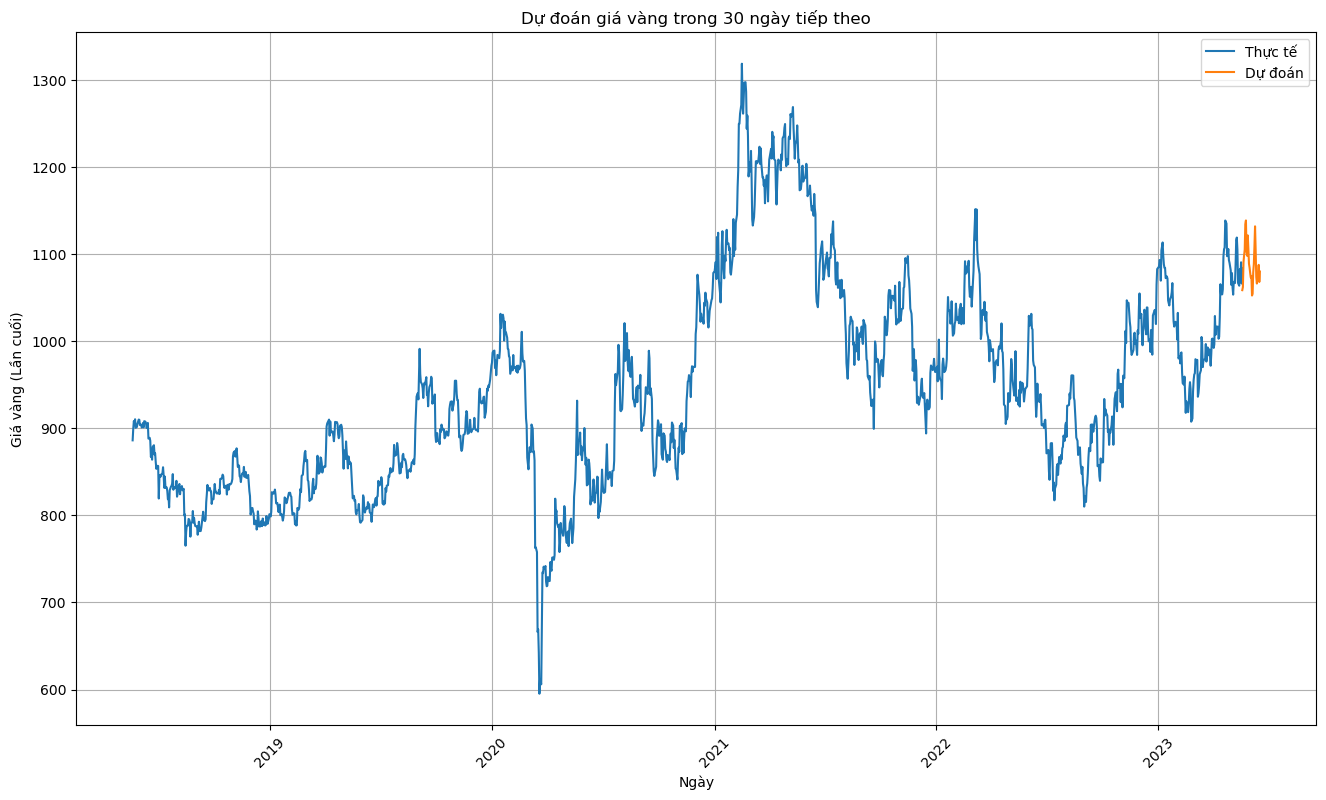

In [6]:
import matplotlib.pyplot as plt

# Lấy 30 ngày cuối cùng từ tập dữ liệu gốc để tạo future_features
last_30_days = data_Platium[-30:]

# Xóa cột "Lần cuối" trong future_features vì đây là giá trị chúng ta muốn dự đoán
future_features = last_30_days.drop(columns=['Lần cuối'])

# Dự đoán giá vàng trong 30 ngày tiếp theo
predicted_prices = model.predict(future_features)


# Tạo một mảng chứa 30 ngày tiếp theo
future_dates = pd.date_range(start=data_Platium.index[-1], periods=30, freq='D')

# Biểu diễn dự đoán lên đồ thị
plt.figure(figsize=(16, 9))
plt.plot(data_Platium.index, data_Platium['Lần cuối'], label='Thực tế')
plt.plot(future_dates, predicted_prices, label='Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng (Lần cuối)')
plt.title('Dự đoán giá vàng trong 30 ngày tiếp theo')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Đánh giá mô hình

In [7]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_validate_pred = model.predict(X_validate)

# Đánh giá mô hình bằng MAE
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_validate = mean_absolute_error(y_validate, y_validate_pred)
print("Mean Absolute Error (MAE) - Test:", mae_test)
print("Mean Absolute Error (MAE) - Validate:", mae_validate)

# Đánh giá mô hình bằng RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
rmse_validate = np.sqrt(mean_squared_error(y_validate, y_validate_pred))
print("Root Mean Squared Error (RMSE) - Test:", rmse_test)
print("Root Mean Squared Error (RMSE) - Validate:", rmse_validate)

# Đánh giá mô hình bằng MAPE
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
mape_validate = np.mean(np.abs((y_validate - y_validate_pred) / y_validate)) * 100
print("Mean Absolute Percentage Error (MAPE) - Test:", mape_test)
print("Mean Absolute Percentage Error (MAPE) - Validate:", mape_validate)

Mean Absolute Error (MAE) - Test: 6.218763761467924
Mean Absolute Error (MAE) - Validate: 6.08220478723403
Root Mean Squared Error (RMSE) - Test: 8.873103366987195
Root Mean Squared Error (RMSE) - Validate: 8.408901443591304
Mean Absolute Percentage Error (MAPE) - Test: 0.6731005424395997
Mean Absolute Percentage Error (MAPE) - Validate: 0.6507205269894802
